<a href="https://colab.research.google.com/github/firdowsacige/brain_tumor/blob/main/Deeplabv3%2B_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:

# Mount Google Drive (Optional, if saving models)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
pip install tensorflow

In [27]:
!pip install opencv-python-headless


In [28]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 224,224
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

In [29]:
!pip install wget
import wget
import zipfile

In [30]:
url = "http://datasets.simula.no/downloads/kvasir-seg.zip"
zip_path = "kvasir-seg.zip"
wget.download(url, zip_path)

'kvasir-seg (1).zip'

In [31]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/kvasir_seg")

In [32]:
!pip install torchinfo


In [33]:
import os
import pandas as pd
from sklearn.utils import shuffle

# Your directories
image_dir = "/content/kvasir_seg/Kvasir-SEG/images"
mask_dir = "/content/kvasir_seg/Kvasir-SEG/masks"

# List image and mask files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Make full paths
images = [os.path.join(image_dir, img) for img in image_files]
masks = [os.path.join(mask_dir, msk) for msk in mask_files]

# Create DataFrame
full_data = pd.DataFrame({'image': images, 'mask': masks})

# Shuffle the data
full_data = shuffle(full_data).reset_index(drop=True)

# Show a few rows
display(full_data.head())


,image,mask
0,/content/kvasir_seg/Kvasir-SEG/images/cju1cj3f...,/content/kvasir_seg/Kvasir-SEG/masks/cju1cj3f0...
1,/content/kvasir_seg/Kvasir-SEG/images/cju77230...,/content/kvasir_seg/Kvasir-SEG/masks/cju772304...
2,/content/kvasir_seg/Kvasir-SEG/images/cju31t8x...,/content/kvasir_seg/Kvasir-SEG/masks/cju31t8xd...
3,/content/kvasir_seg/Kvasir-SEG/images/cju8apje...,/content/kvasir_seg/Kvasir-SEG/masks/cju8apjew...
4,/content/kvasir_seg/Kvasir-SEG/images/cju7et17...,/content/kvasir_seg/Kvasir-SEG/masks/cju7et17a...


In [59]:
X_data, X_test, y_data, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.2, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.2, random_state = SEED )

print("X_train shape -> ", X_data.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (800,)
X_val shape ->  (160,)
X_test shape ->  (200,)


In [60]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

In [61]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_data, y_data))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_data.shape[0])
                 .prefetch(AUTO))


validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [62]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias

        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)

    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }

In [63]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4

        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)


    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X


    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, AveragePooling2D, Conv2D, UpSampling2D, Concatenate

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4):
        super().__init__()
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))  # use smaller pool if needed
        self.upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')

        self.convout1 = Conv2D(256, kernel_1, dilation_rate=dil1, padding='same')
        self.convout2 = Conv2D(256, kernel_2, dilation_rate=dil2, padding='same')
        self.convout3 = Conv2D(256, kernel_3, dilation_rate=dil3, padding='same')
        self.convout4 = Conv2D(256, kernel_4, dilation_rate=dil4, padding='same')
        self.outconv = Conv2D(256, 1, padding='same')

    def call(self, inputs):
        input_shape = tf.shape(inputs)[1:3]  # get spatial size dynamically (e.g., 14x14)

        X_p = self.avg_pool(inputs)
        X_p = self.upsample(X_p)  # bring to input spatial size (14x14)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)

        # Make sure all shapes are the same before concatenation
        X_p = tf.image.resize(X_p, input_shape, method='bilinear')

        C = Concatenate(axis=-1)([X_p, X_1, X_2, X_3, X_4])
        X = self.outconv(C)
        return X



    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}


In [65]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [66]:
# Custom callback for predicting one sample from test dataset during training each epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):

        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))

            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs

            image = samples[batch_idx][0][image_idx]
            mask = samples[batch_idx][1][image_idx]

            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)

            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)

            plt.tight_layout()
            plt.show()
        else:
            pass


In [67]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
dsp_block = DilatedSpatialPyramidPooling(kernel_1=1, kernel_2=3, kernel_3=3, kernel_4=3,
                                         dil1=1, dil2=6, dil3=12, dil4=18)
X = dsp_block(X)


X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard])
my_callbacks = [PredictDuringTraining()]


Epoch 1/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.3275 - dice_coef_loss: 0.6725 - jaccard: 0.2037 - loss: 0.5691

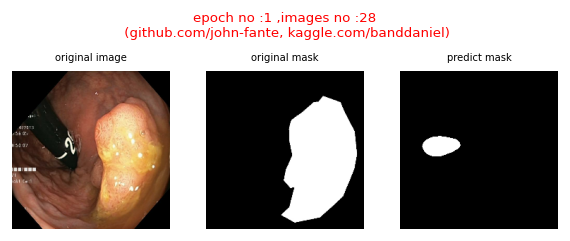

100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 123ms/step - dice_coef: 0.3296 - dice_coef_loss: 0.6704 - jaccard: 0.2052 - loss: 0.5647 - val_dice_coef: 0.1331 - val_dice_coef_loss: 0.8669 - val_jaccard: 0.0714 - val_loss: 0.6704
Epoch 2/40
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.6106 - dice_coef_loss: 0.3894 - jaccard: 0.4433 - loss: 0.1959

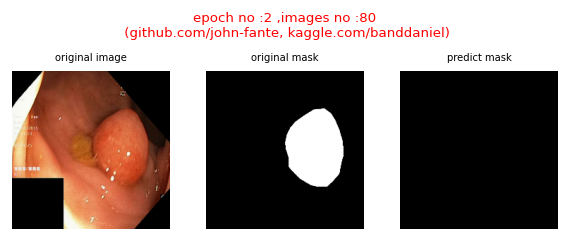

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.6108 - dice_coef_loss: 0.3892 - jaccard: 0.4435 - loss: 0.1959 - val_dice_coef: 0.0423 - val_dice_coef_loss: 0.9577 - val_jaccard: 0.0216 - val_loss: 0.6112
Epoch 3/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.7015 - dice_coef_loss: 0.2985 - jaccard: 0.5440 - loss: 0.1579

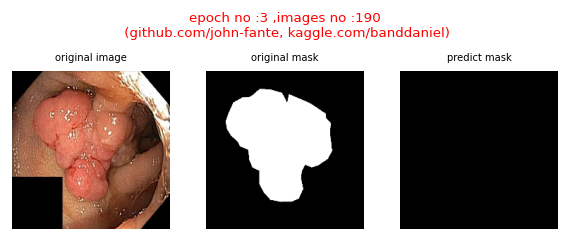

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - dice_coef: 0.7019 - dice_coef_loss: 0.2981 - jaccard: 0.5444 - loss: 0.1578 - val_dice_coef: 0.0032 - val_dice_coef_loss: 0.9968 - val_jaccard: 0.0016 - val_loss: 1.0090
Epoch 4/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.7536 - dice_coef_loss: 0.2464 - jaccard: 0.6094 - loss: 0.1134

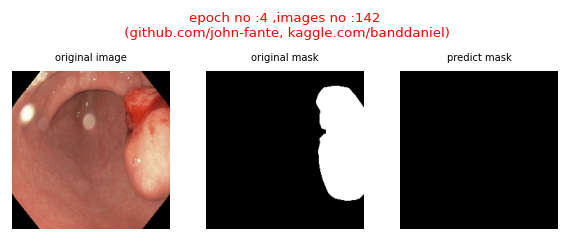

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.7540 - dice_coef_loss: 0.2460 - jaccard: 0.6098 - loss: 0.1135 - val_dice_coef: 0.0167 - val_dice_coef_loss: 0.9833 - val_jaccard: 0.0084 - val_loss: 0.7270
Epoch 5/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.7687 - dice_coef_loss: 0.2313 - jaccard: 0.6290 - loss: 0.1208

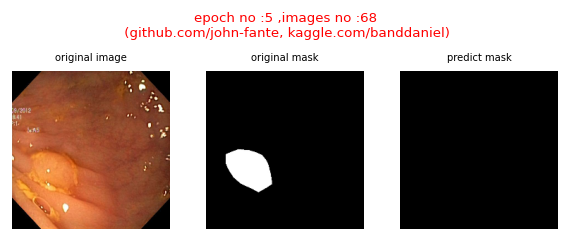

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.7689 - dice_coef_loss: 0.2311 - jaccard: 0.6291 - loss: 0.1207 - val_dice_coef: 0.0080 - val_dice_coef_loss: 0.9920 - val_jaccard: 0.0040 - val_loss: 0.9359
Epoch 6/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.8340 - dice_coef_loss: 0.1660 - jaccard: 0.7175 - loss: 0.0846

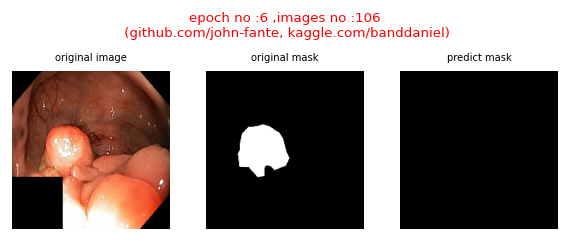

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.8339 - dice_coef_loss: 0.1661 - jaccard: 0.7174 - loss: 0.0847 - val_dice_coef: 0.0166 - val_dice_coef_loss: 0.9834 - val_jaccard: 0.0085 - val_loss: 1.3260
Epoch 7/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.8234 - dice_coef_loss: 0.1766 - jaccard: 0.7050 - loss: 0.0966

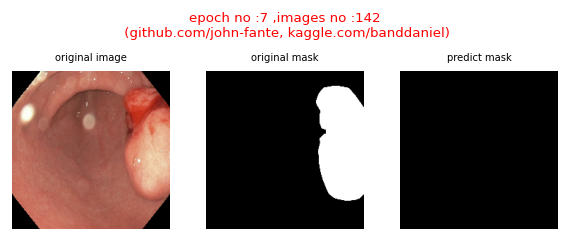

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.8234 - dice_coef_loss: 0.1766 - jaccard: 0.7050 - loss: 0.0965 - val_dice_coef: 0.2093 - val_dice_coef_loss: 0.7907 - val_jaccard: 0.1188 - val_loss: 0.6580
Epoch 8/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.8824 - dice_coef_loss: 0.1176 - jaccard: 0.7911 - loss: 0.0592

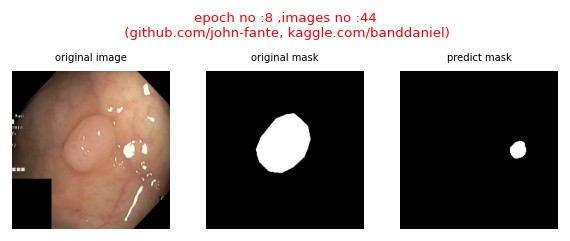

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.8825 - dice_coef_loss: 0.1175 - jaccard: 0.7914 - loss: 0.0592 - val_dice_coef: 0.3763 - val_dice_coef_loss: 0.6237 - val_jaccard: 0.2384 - val_loss: 0.6487
Epoch 9/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9239 - dice_coef_loss: 0.0761 - jaccard: 0.8591 - loss: 0.0406

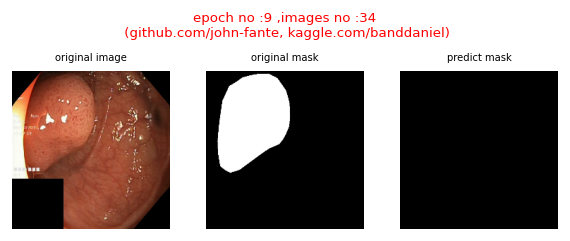

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - dice_coef: 0.9238 - dice_coef_loss: 0.0762 - jaccard: 0.8589 - loss: 0.0406 - val_dice_coef: 0.4204 - val_dice_coef_loss: 0.5796 - val_jaccard: 0.2761 - val_loss: 0.5434
Epoch 10/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9304 - dice_coef_loss: 0.0696 - jaccard: 0.8704 - loss: 0.0346

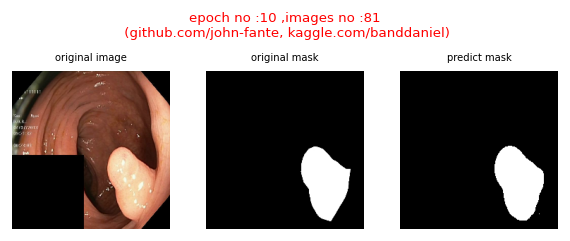

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9304 - dice_coef_loss: 0.0696 - jaccard: 0.8704 - loss: 0.0346 - val_dice_coef: 0.7999 - val_dice_coef_loss: 0.2001 - val_jaccard: 0.6749 - val_loss: 0.1631
Epoch 11/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9386 - dice_coef_loss: 0.0614 - jaccard: 0.8848 - loss: 0.0310

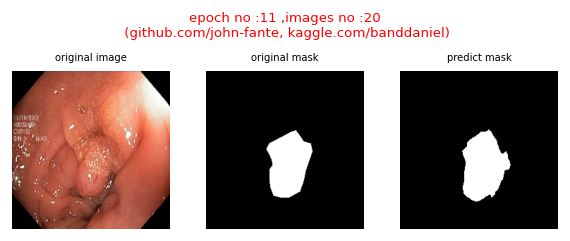

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9385 - dice_coef_loss: 0.0615 - jaccard: 0.8845 - loss: 0.0311 - val_dice_coef: 0.8744 - val_dice_coef_loss: 0.1256 - val_jaccard: 0.7785 - val_loss: 0.0737
Epoch 12/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.8538 - dice_coef_loss: 0.1462 - jaccard: 0.7506 - loss: 0.0772

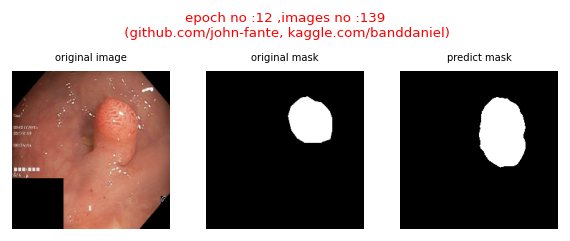

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.8534 - dice_coef_loss: 0.1466 - jaccard: 0.7499 - loss: 0.0774 - val_dice_coef: 0.7613 - val_dice_coef_loss: 0.2387 - val_jaccard: 0.6180 - val_loss: 0.1343
Epoch 13/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.8678 - dice_coef_loss: 0.1322 - jaccard: 0.7686 - loss: 0.0660

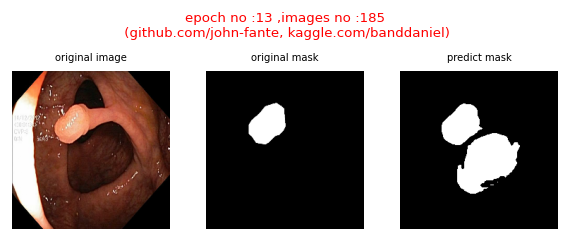

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - dice_coef: 0.8680 - dice_coef_loss: 0.1320 - jaccard: 0.7689 - loss: 0.0660 - val_dice_coef: 0.8022 - val_dice_coef_loss: 0.1978 - val_jaccard: 0.6714 - val_loss: 0.1107
Epoch 14/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9196 - dice_coef_loss: 0.0804 - jaccard: 0.8520 - loss: 0.0387

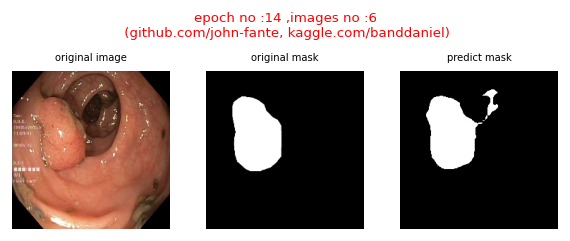

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9197 - dice_coef_loss: 0.0803 - jaccard: 0.8521 - loss: 0.0387 - val_dice_coef: 0.9250 - val_dice_coef_loss: 0.0750 - val_jaccard: 0.8609 - val_loss: 0.0394
Epoch 15/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9388 - dice_coef_loss: 0.0612 - jaccard: 0.8850 - loss: 0.0291

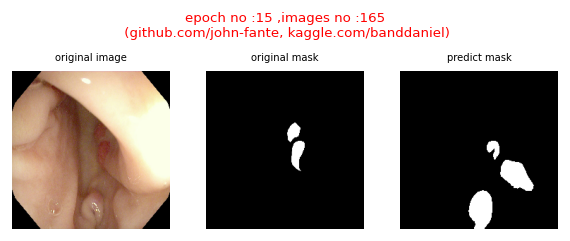

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9389 - dice_coef_loss: 0.0611 - jaccard: 0.8851 - loss: 0.0291 - val_dice_coef: 0.9518 - val_dice_coef_loss: 0.0482 - val_jaccard: 0.9082 - val_loss: 0.0235
Epoch 16/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9544 - dice_coef_loss: 0.0456 - jaccard: 0.9130 - loss: 0.0214

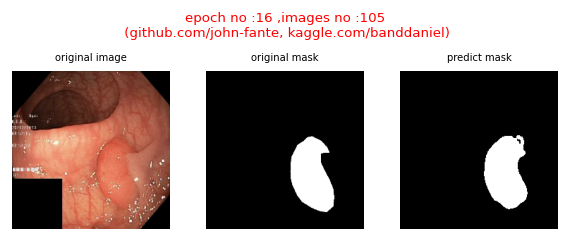

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9544 - dice_coef_loss: 0.0456 - jaccard: 0.9130 - loss: 0.0215 - val_dice_coef: 0.9517 - val_dice_coef_loss: 0.0483 - val_jaccard: 0.9080 - val_loss: 0.0225
Epoch 17/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9554 - dice_coef_loss: 0.0446 - jaccard: 0.9148 - loss: 0.0209

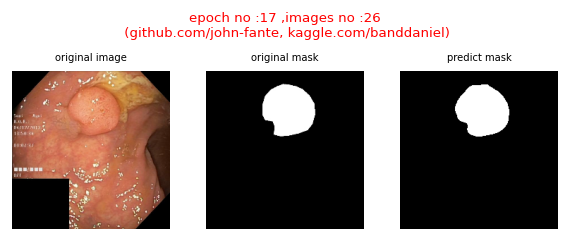

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9555 - dice_coef_loss: 0.0445 - jaccard: 0.9149 - loss: 0.0209 - val_dice_coef: 0.9606 - val_dice_coef_loss: 0.0394 - val_jaccard: 0.9244 - val_loss: 0.0185
Epoch 18/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9636 - dice_coef_loss: 0.0364 - jaccard: 0.9299 - loss: 0.0191

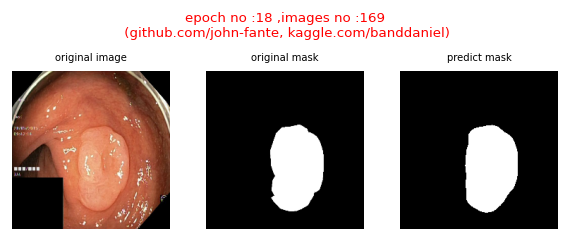

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9636 - dice_coef_loss: 0.0364 - jaccard: 0.9298 - loss: 0.0191 - val_dice_coef: 0.9597 - val_dice_coef_loss: 0.0403 - val_jaccard: 0.9226 - val_loss: 0.0202
Epoch 19/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9640 - dice_coef_loss: 0.0360 - jaccard: 0.9305 - loss: 0.0175

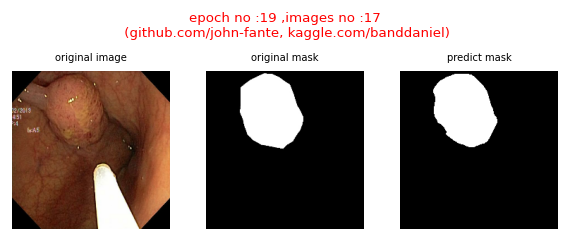

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - dice_coef: 0.9640 - dice_coef_loss: 0.0360 - jaccard: 0.9305 - loss: 0.0175 - val_dice_coef: 0.9646 - val_dice_coef_loss: 0.0354 - val_jaccard: 0.9316 - val_loss: 0.0167
Epoch 20/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9660 - dice_coef_loss: 0.0340 - jaccard: 0.9343 - loss: 0.0164

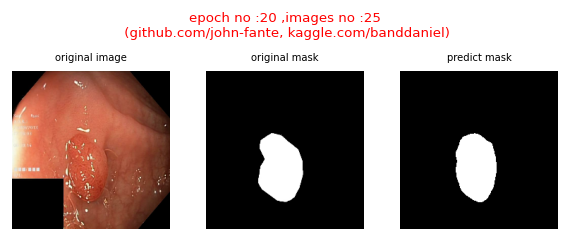

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9660 - dice_coef_loss: 0.0340 - jaccard: 0.9343 - loss: 0.0164 - val_dice_coef: 0.9668 - val_dice_coef_loss: 0.0332 - val_jaccard: 0.9359 - val_loss: 0.0157
Epoch 21/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9670 - dice_coef_loss: 0.0330 - jaccard: 0.9362 - loss: 0.0159

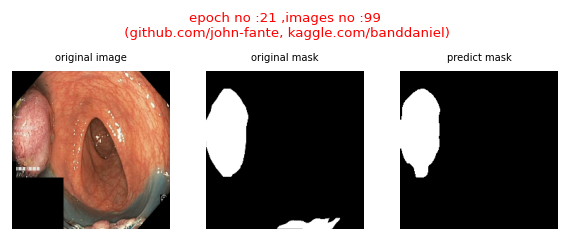

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9670 - dice_coef_loss: 0.0330 - jaccard: 0.9362 - loss: 0.0159 - val_dice_coef: 0.9657 - val_dice_coef_loss: 0.0343 - val_jaccard: 0.9338 - val_loss: 0.0156
Epoch 22/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9684 - dice_coef_loss: 0.0316 - jaccard: 0.9389 - loss: 0.0146

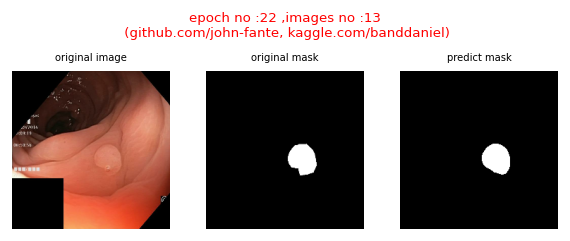

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9684 - dice_coef_loss: 0.0316 - jaccard: 0.9389 - loss: 0.0146 - val_dice_coef: 0.9695 - val_dice_coef_loss: 0.0305 - val_jaccard: 0.9409 - val_loss: 0.0152
Epoch 23/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9718 - dice_coef_loss: 0.0282 - jaccard: 0.9452 - loss: 0.0134

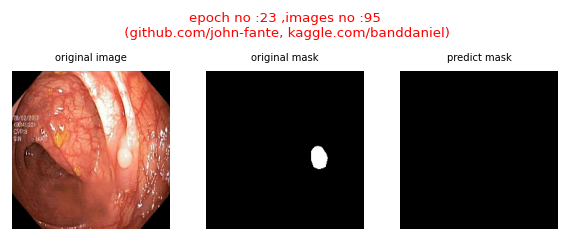

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9718 - dice_coef_loss: 0.0282 - jaccard: 0.9451 - loss: 0.0134 - val_dice_coef: 0.9645 - val_dice_coef_loss: 0.0355 - val_jaccard: 0.9316 - val_loss: 0.0178
Epoch 24/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9725 - dice_coef_loss: 0.0275 - jaccard: 0.9465 - loss: 0.0139

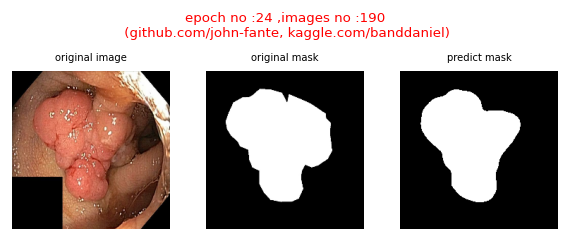

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9725 - dice_coef_loss: 0.0275 - jaccard: 0.9464 - loss: 0.0139 - val_dice_coef: 0.9722 - val_dice_coef_loss: 0.0278 - val_jaccard: 0.9459 - val_loss: 0.0137
Epoch 25/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9722 - dice_coef_loss: 0.0278 - jaccard: 0.9459 - loss: 0.0132

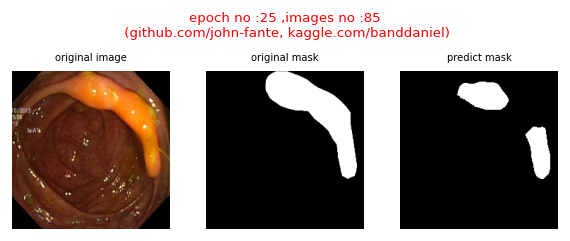

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9722 - dice_coef_loss: 0.0278 - jaccard: 0.9460 - loss: 0.0132 - val_dice_coef: 0.9735 - val_dice_coef_loss: 0.0265 - val_jaccard: 0.9484 - val_loss: 0.0129
Epoch 26/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9734 - dice_coef_loss: 0.0266 - jaccard: 0.9482 - loss: 0.0127

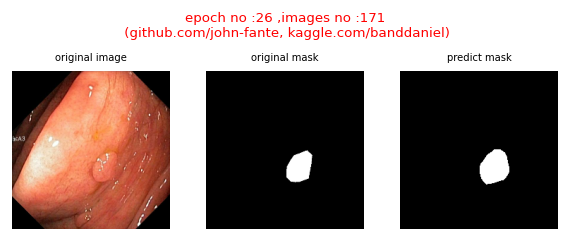

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9734 - dice_coef_loss: 0.0266 - jaccard: 0.9482 - loss: 0.0127 - val_dice_coef: 0.9729 - val_dice_coef_loss: 0.0271 - val_jaccard: 0.9473 - val_loss: 0.0130
Epoch 27/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9730 - dice_coef_loss: 0.0270 - jaccard: 0.9475 - loss: 0.0131

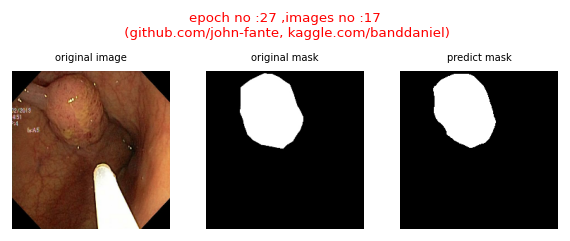

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9730 - dice_coef_loss: 0.0270 - jaccard: 0.9475 - loss: 0.0131 - val_dice_coef: 0.9734 - val_dice_coef_loss: 0.0266 - val_jaccard: 0.9483 - val_loss: 0.0127
Epoch 28/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9756 - dice_coef_loss: 0.0244 - jaccard: 0.9524 - loss: 0.0121

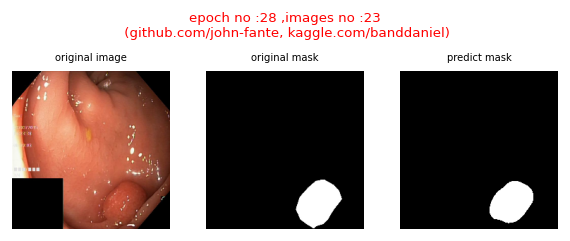

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9756 - dice_coef_loss: 0.0244 - jaccard: 0.9524 - loss: 0.0121 - val_dice_coef: 0.9745 - val_dice_coef_loss: 0.0255 - val_jaccard: 0.9503 - val_loss: 0.0122
Epoch 29/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9745 - dice_coef_loss: 0.0255 - jaccard: 0.9503 - loss: 0.0131

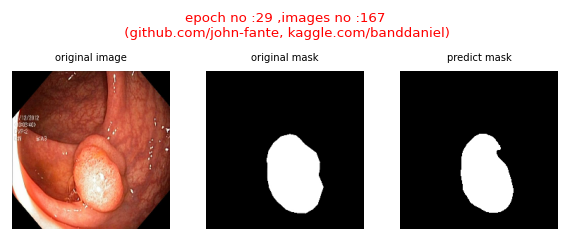

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9745 - dice_coef_loss: 0.0255 - jaccard: 0.9503 - loss: 0.0131 - val_dice_coef: 0.9749 - val_dice_coef_loss: 0.0251 - val_jaccard: 0.9512 - val_loss: 0.0120
Epoch 30/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9762 - dice_coef_loss: 0.0238 - jaccard: 0.9535 - loss: 0.0121

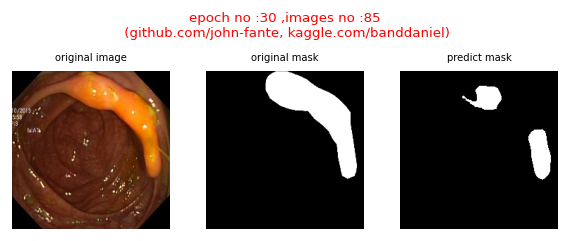

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - dice_coef: 0.9762 - dice_coef_loss: 0.0238 - jaccard: 0.9535 - loss: 0.0121 - val_dice_coef: 0.9767 - val_dice_coef_loss: 0.0233 - val_jaccard: 0.9546 - val_loss: 0.0112
Epoch 31/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9767 - dice_coef_loss: 0.0233 - jaccard: 0.9545 - loss: 0.0116

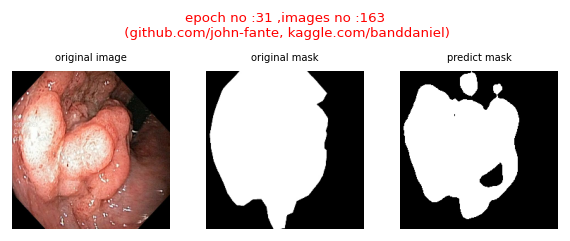

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9767 - dice_coef_loss: 0.0233 - jaccard: 0.9545 - loss: 0.0116 - val_dice_coef: 0.9763 - val_dice_coef_loss: 0.0237 - val_jaccard: 0.9537 - val_loss: 0.0113
Epoch 32/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.9773 - dice_coef_loss: 0.0227 - jaccard: 0.9556 - loss: 0.0114

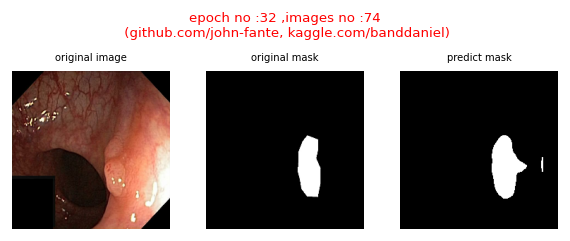

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - dice_coef: 0.9773 - dice_coef_loss: 0.0227 - jaccard: 0.9556 - loss: 0.0114 - val_dice_coef: 0.9764 - val_dice_coef_loss: 0.0236 - val_jaccard: 0.9540 - val_loss: 0.0111
Epoch 33/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9778 - dice_coef_loss: 0.0222 - jaccard: 0.9565 - loss: 0.0104

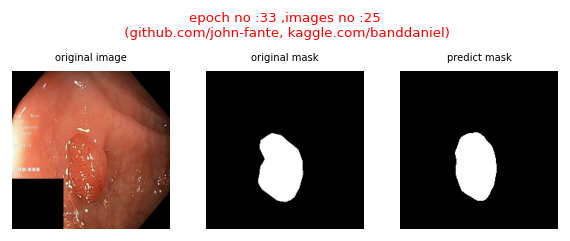

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9778 - dice_coef_loss: 0.0222 - jaccard: 0.9565 - loss: 0.0104 - val_dice_coef: 0.9762 - val_dice_coef_loss: 0.0238 - val_jaccard: 0.9536 - val_loss: 0.0111
Epoch 34/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9769 - dice_coef_loss: 0.0231 - jaccard: 0.9548 - loss: 0.0113

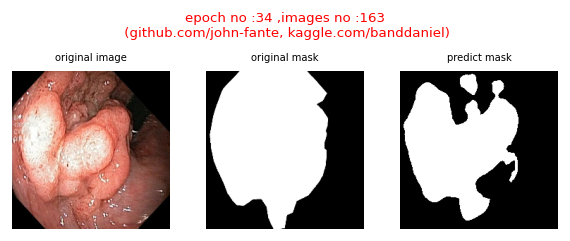

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9769 - dice_coef_loss: 0.0231 - jaccard: 0.9548 - loss: 0.0113 - val_dice_coef: 0.9761 - val_dice_coef_loss: 0.0239 - val_jaccard: 0.9534 - val_loss: 0.0114
Epoch 35/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9775 - dice_coef_loss: 0.0225 - jaccard: 0.9560 - loss: 0.0114

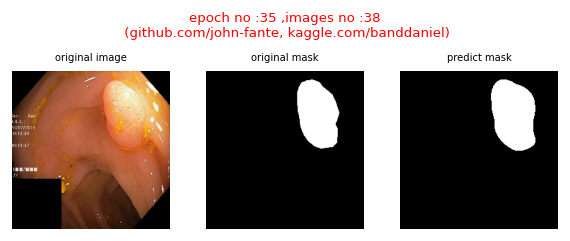

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9775 - dice_coef_loss: 0.0225 - jaccard: 0.9559 - loss: 0.0114 - val_dice_coef: 0.9764 - val_dice_coef_loss: 0.0236 - val_jaccard: 0.9540 - val_loss: 0.0115
Epoch 36/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9778 - dice_coef_loss: 0.0222 - jaccard: 0.9567 - loss: 0.0107

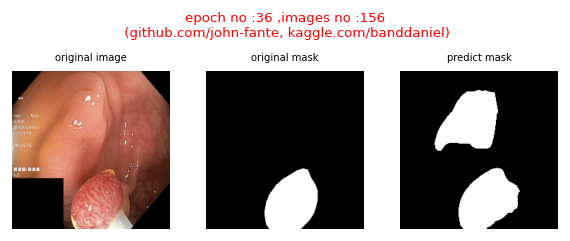

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9778 - dice_coef_loss: 0.0222 - jaccard: 0.9567 - loss: 0.0107 - val_dice_coef: 0.9775 - val_dice_coef_loss: 0.0225 - val_jaccard: 0.9559 - val_loss: 0.0106
Epoch 37/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9783 - dice_coef_loss: 0.0217 - jaccard: 0.9575 - loss: 0.0105

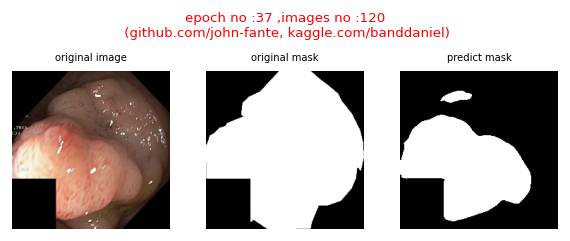

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - dice_coef: 0.9783 - dice_coef_loss: 0.0217 - jaccard: 0.9575 - loss: 0.0105 - val_dice_coef: 0.9780 - val_dice_coef_loss: 0.0220 - val_jaccard: 0.9571 - val_loss: 0.0107
Epoch 38/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9780 - dice_coef_loss: 0.0220 - jaccard: 0.9570 - loss: 0.0108

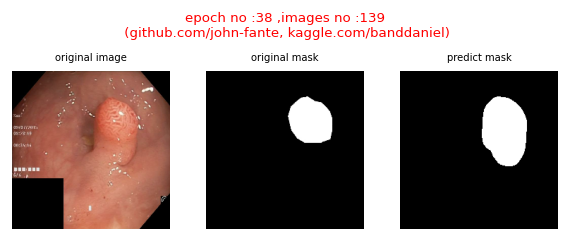

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9780 - dice_coef_loss: 0.0220 - jaccard: 0.9570 - loss: 0.0107 - val_dice_coef: 0.9770 - val_dice_coef_loss: 0.0230 - val_jaccard: 0.9550 - val_loss: 0.0115
Epoch 39/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9581 - loss: 0.0103

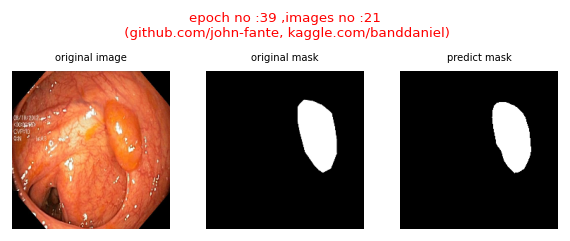

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9786 - dice_coef_loss: 0.0214 - jaccard: 0.9581 - loss: 0.0103 - val_dice_coef: 0.9786 - val_dice_coef_loss: 0.0214 - val_jaccard: 0.9582 - val_loss: 0.0102
Epoch 40/40
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.9790 - dice_coef_loss: 0.0210 - jaccard: 0.9590 - loss: 0.0105

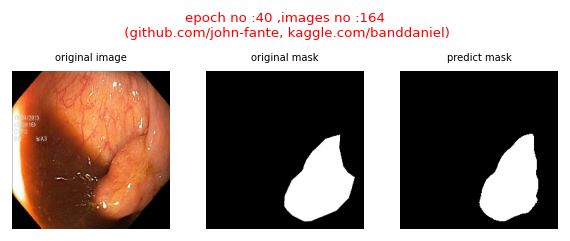

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - dice_coef: 0.9790 - dice_coef_loss: 0.0210 - jaccard: 0.9590 - loss: 0.0105 - val_dice_coef: 0.9789 - val_dice_coef_loss: 0.0211 - val_jaccard: 0.9587 - val_loss: 0.0107


In [68]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 40, validation_data = validation_dataset, callbacks = my_callbacks)


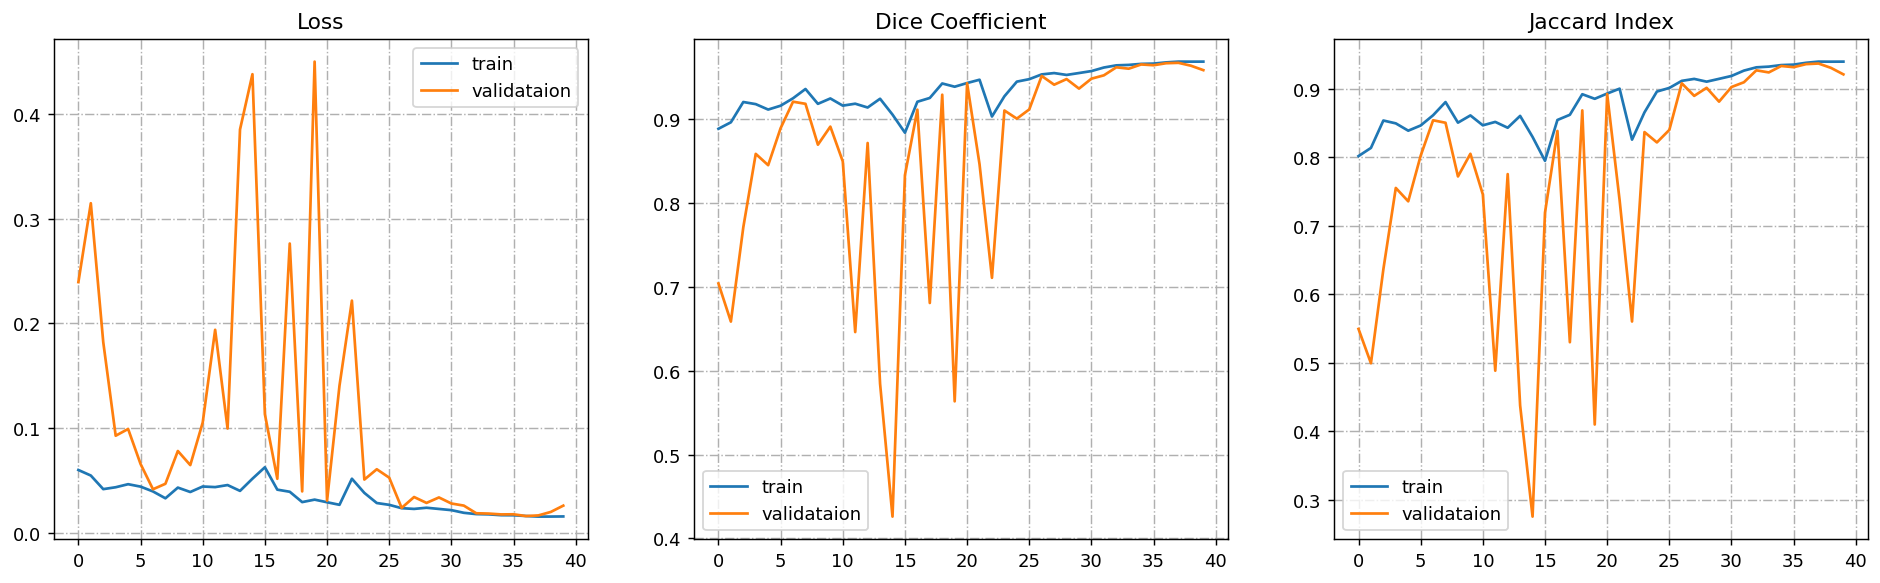

In [51]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['val_dice_coef'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].plot(hist.history['val_jaccard'])
axs[2].legend(["train",  "validataion"])

In [52]:
val_eval = model.evaluate(validation_dataset)
test_eval = model.evaluate(test_dataset)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - dice_coef: 0.9622 - dice_coef_loss: 0.0378 - jaccard: 0.9274 - loss: 0.0213
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - dice_coef: 0.8580 - dice_coef_loss: 0.1420 - jaccard: 0.7601 - loss: 0.2384


In [53]:
test_take1 =  validation_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

pred_ = np.squeeze(pred)

threshold_1  = 0.3 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.99 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step


In [69]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint16)
    y_pred_f = tf.cast(y_pred_f, tf.uint16)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs


    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)

    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]

        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]


        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.3 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1)
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)

        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.99 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

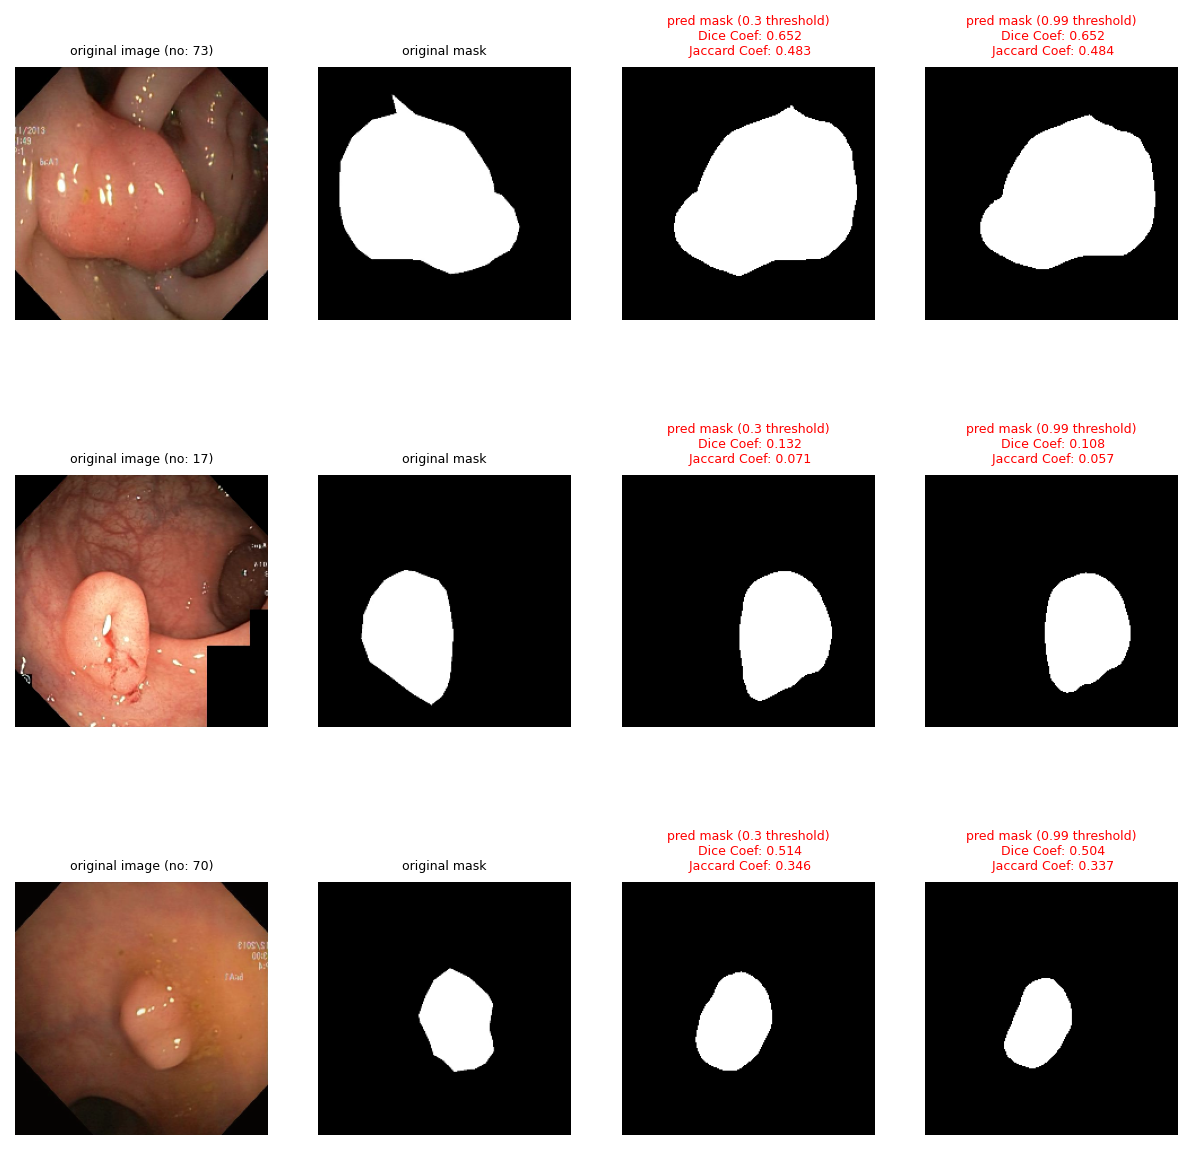

In [70]:
random_test_sample_with_prediction()